# Zillow EDA on Missing Values & Multicollinearity
https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity

## 해당 노트북이 다루는 주제
- 결측치 분석
- 상관 분석
- XGBoost를 통한 중요 피쳐 분석
- 다중공선성
- 일변량 분석
- 이변량 분석

## Import

In [75]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
%matplotlib inline

## 데이터 불러오기

In [76]:
train = pd.read_csv('./input/train_2016_v2.csv', parse_dates=['transactiondate'])
properties = pd.read_csv('./input/properties_2016.csv')

## 데이터 형태

In [77]:
print('Train:', train.shape)
print('Properties:', properties.shape)

Train: (90275, 3)
Properties: (2985217, 58)


## train과 properties 병합

In [78]:
merged = pd.merge(train, properties, on='parcelid', how='left')

In [79]:
merged.head(3).transpose()

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
airconditioningtypeid,1.0,NaN,1.0
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2.0,3.5,3.0
bedroomcnt,3.0,4.0,2.0
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4.0,NaN,4.0


## 데이터 타입 시각화 

<AxesSubplot:>

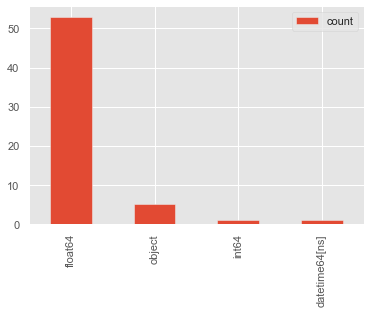

In [80]:
dataTypeDf = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
dataTypeDf.plot(kind='bar', x="variableType",y="count", xlabel='')

## 결측치 분석

<AxesSubplot:>

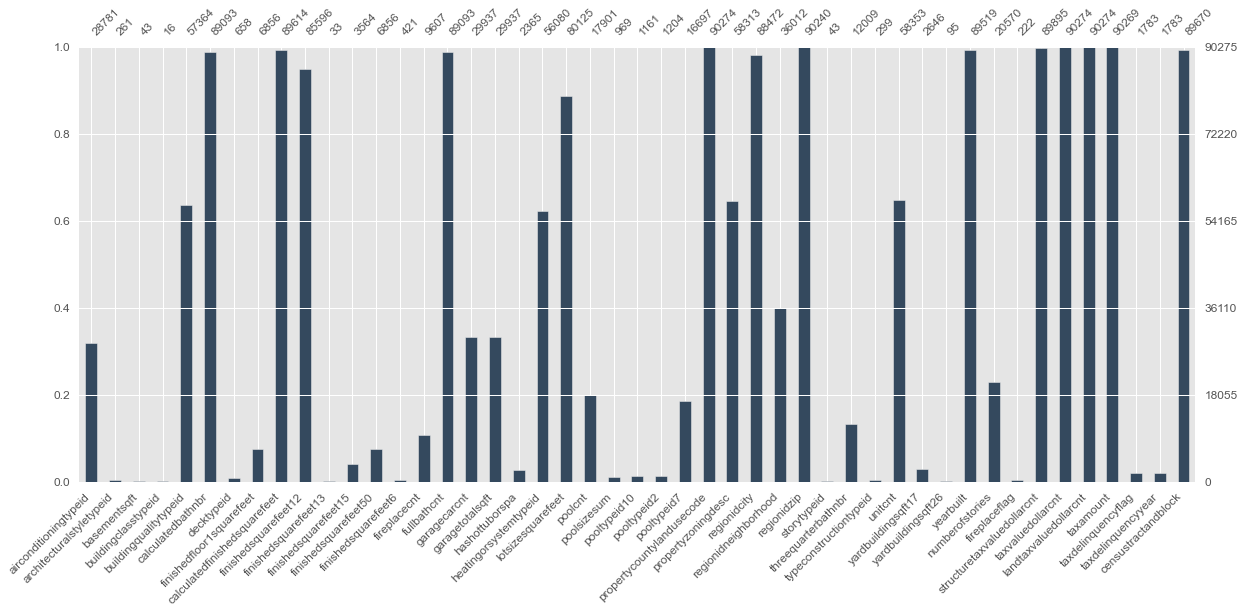

In [81]:
missingValueColumns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missingValueColumns], figsize=(20, 8), color='#34495e', fontsize=12, labels=True)

<AxesSubplot:>

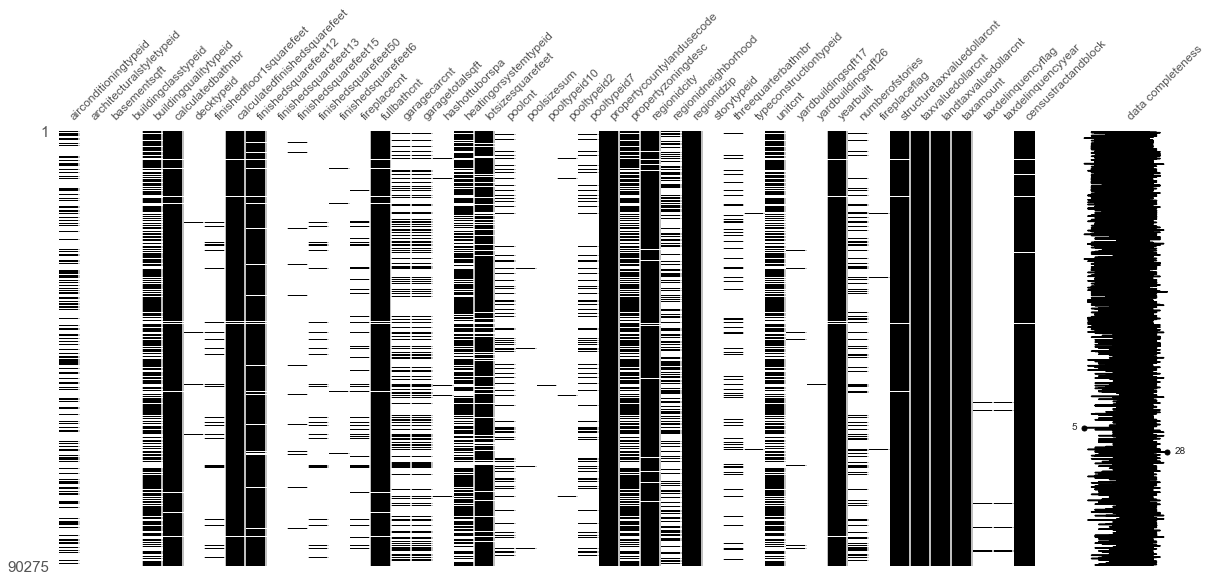

In [82]:
msno.matrix(merged[missingValueColumns], width_ratios=(10, 1), figsize=(20, 8), color=(0,0,0), fontsize=12, sparkline=True, labels=True)

<AxesSubplot:>

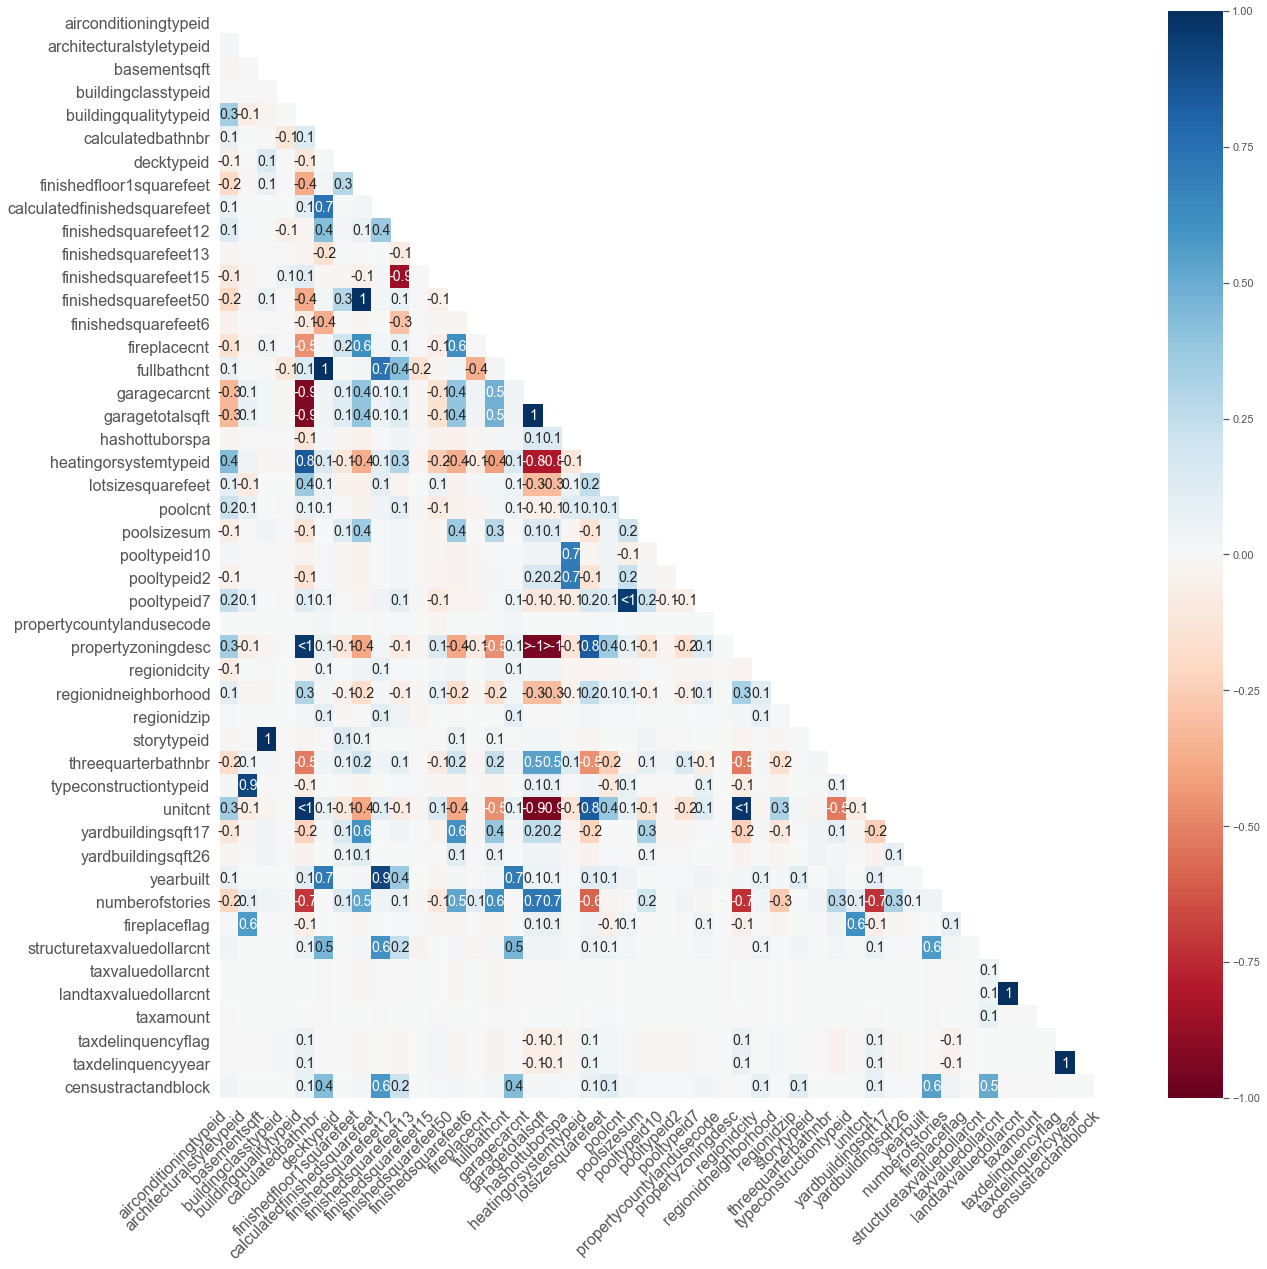

In [83]:
msno.heatmap(merged[missingValueColumns], figsize=(20, 20))

## 중요 피쳐 선택

In [84]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values))
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
        
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(['parcelid', 'transactiondate', 'logerror'], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': .7,
    'colsample_bytree': .7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

[12:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<AxesSubplot:xlabel='importance', ylabel='features'>

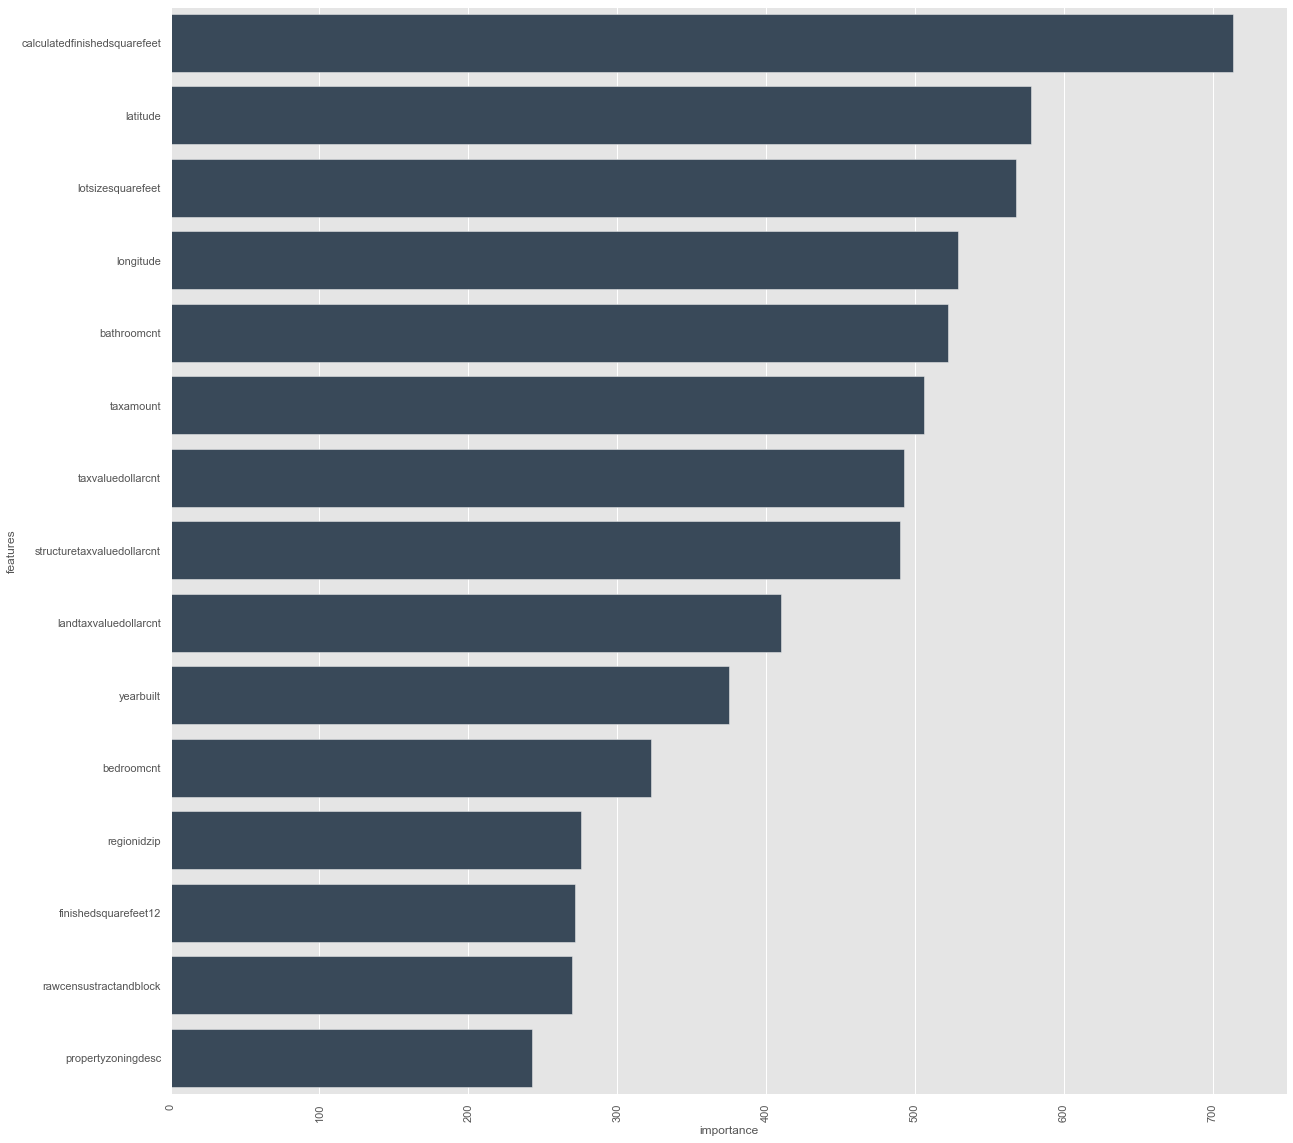

In [85]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'], ascending=False, inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
plt.xticks(rotation=90)
sns.barplot(data=features.head(15), x='importance', y='features', ax=ax, orient='h', color='#34495e')

## 상관 분석

<AxesSubplot:>

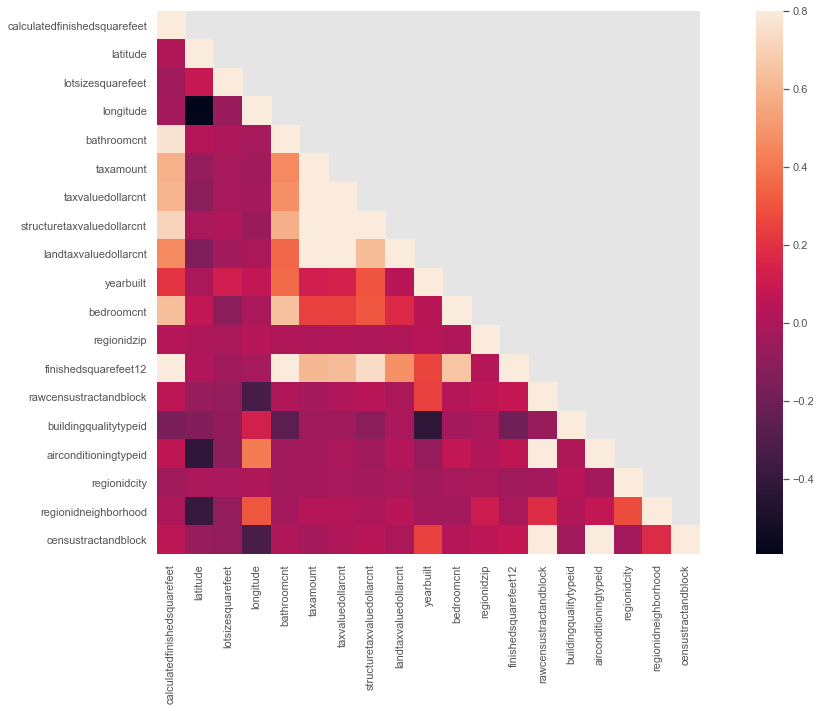

In [86]:
topFeatures = features['features'].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True)

## 다중공선성

[Text(0.5, 0, 'VIF Scores'),
 Text(0, 0.5, 'Features'),
 Text(0.5, 1.0, 'Variables Which Exhibit Multicollinearity')]

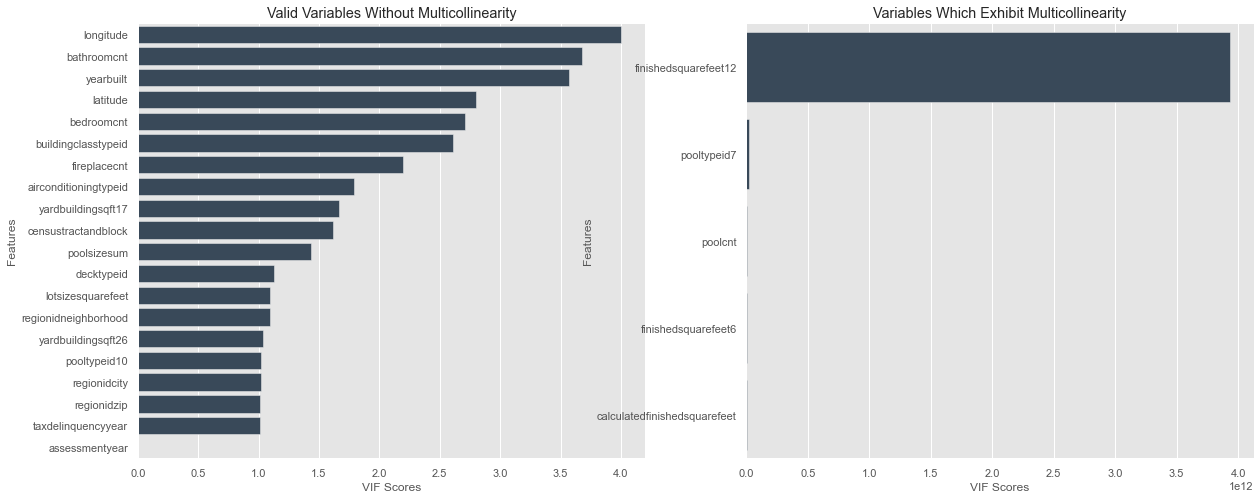

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix, variable in enumerate(list(X.columns))}
    return vif

numericalCol = []
for f in merged.columns:
    if merged[f].dtype != 'object' and f not in ['parcelid', 'transactiondate', 'logerror']:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'], ascending=False, inplace=True)
validVariables = vifDf[vifDf['vifScore']<=5]
variablesWithMC = vifDf[vifDf['vifScore']>5]

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 8)
sns.barplot(data=validVariables, x='vifScore', y='variables', ax=ax1, orient='h', color='#34495e')
sns.barplot(data=variablesWithMC.head(5), x='vifScore', y='variables', ax=ax2, orient='h', color='#34495e')
ax1.set(xlabel='VIF Scores', ylabel='Features', title='Valid Variables Without Multicollinearity')
ax2.set(xlabel='VIF Scores', ylabel='Features', title='Variables Which Exhibit Multicollinearity')

## 일변량 분석
종속 변수인 logerror가 정규분포를 따릅니다.

[Text(0.5, 0, 'logerror'),
 Text(0, 0.5, 'VIF Score'),
 Text(0.5, 1.0, 'Distribution Of Dependent Variable')]

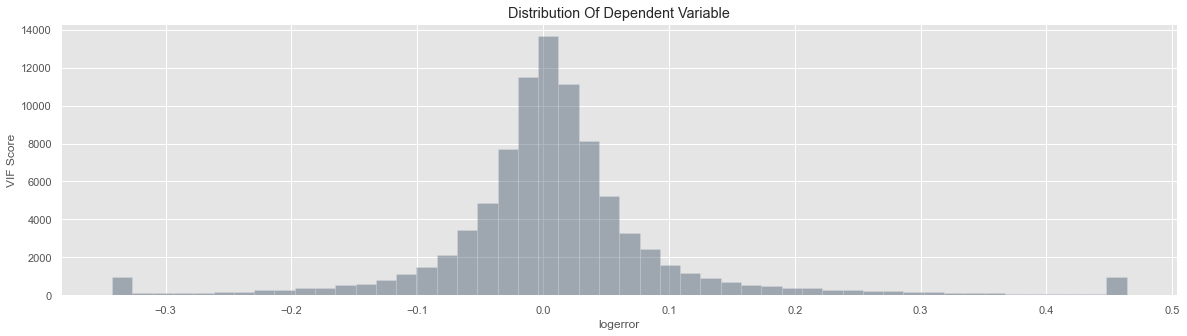

In [92]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'][merged['logerror']>ulimit] = ulimit
merged['logerror'][merged['logerror']<llimit] = llimit

fig, ax = plt.subplots(figsize=(20, 5))
sns.distplot(merged.logerror.values, bins=50, kde=False, color='#34495e', ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score', title='Distribution Of Dependent Variable')

## 이변량 분석

[Text(0.5, 0, 'Month Of The Year'),
 Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 1.0, 'No Of Occurunces Across Month Of 2016'),
 None]

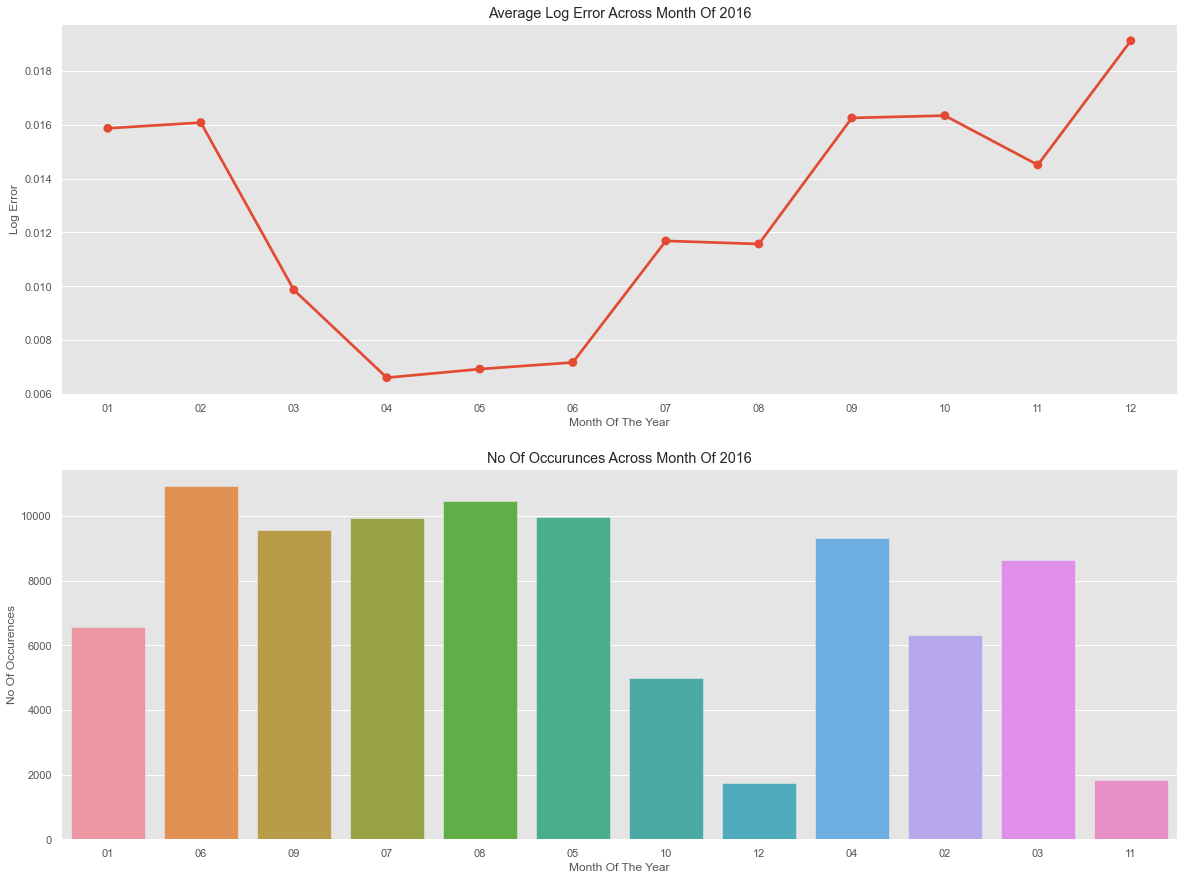

In [100]:
train['year'] = train.transactiondate.map(lambda x: str(x).split('-')[0])
train['month'] = train.transactiondate.map(lambda x: str(x).split('-')[1])
train['day'] = train.transactiondate.map(lambda x: str(x).split('-')[2].split()[0])

traingroupedMonth = train.groupby(['month'])['logerror'].mean().to_frame().reset_index()
traingroupedDay = train.groupby(['day'])['logerror'].mean().to_frame().reset_index()
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(20, 15)

sns.pointplot(x=traingroupedMonth['month'], y=traingroupedMonth['logerror'], data=traingroupedMonth, join=True, ax=ax1)
ax1.set(xlabel="Month Of The Year", ylabel='Log Error', title='Average Log Error Across Month Of 2016', label='big')

sns.countplot(x=train['month'], data=train, ax=ax2)
ax2.set(xlabel="Month Of The Year", ylabel='No Of Occurences', title='No Of Occurunces Across Month Of 2016', label='big')

[Text(0.5, 0, 'Day Of The Month'),
 Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 1.0, 'No Of Occurences Across Days Of The Month In 2016'),
 None]

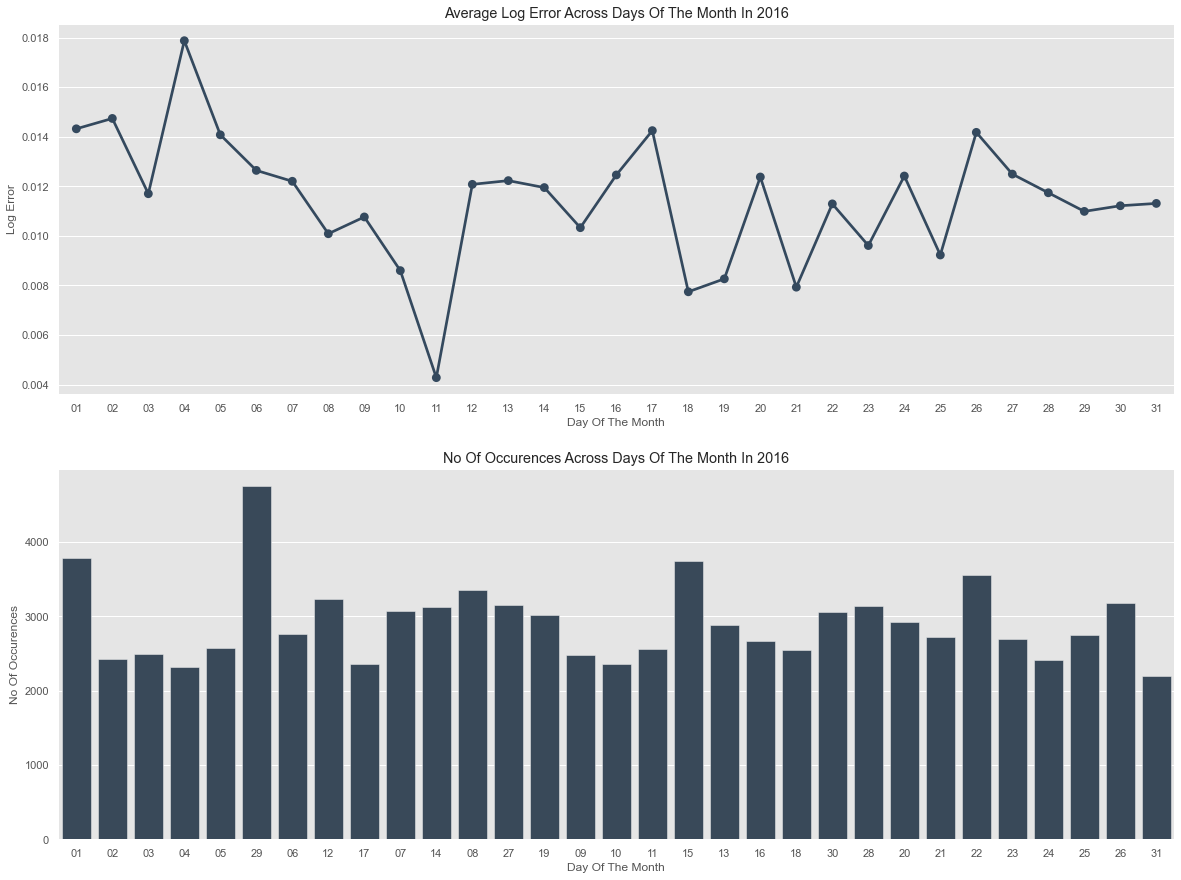

In [102]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sn.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Day Of The Month', ylabel='Log Error',title="Average Log Error Across Days Of The Month In 2016",label='big')

sn.countplot(x=train["day"], data=train,ax=ax2,color="#34495e")
ax2.set(xlabel='Day Of The Month', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Month In 2016",label='big')

## 연도에 따른 건물의 층수
1950년대 이후로 2층 또는 3층보다 높은 건물을 지었다는 것을 알 수 있습니다.

<AxesSubplot:xlabel='yearbuilt'>

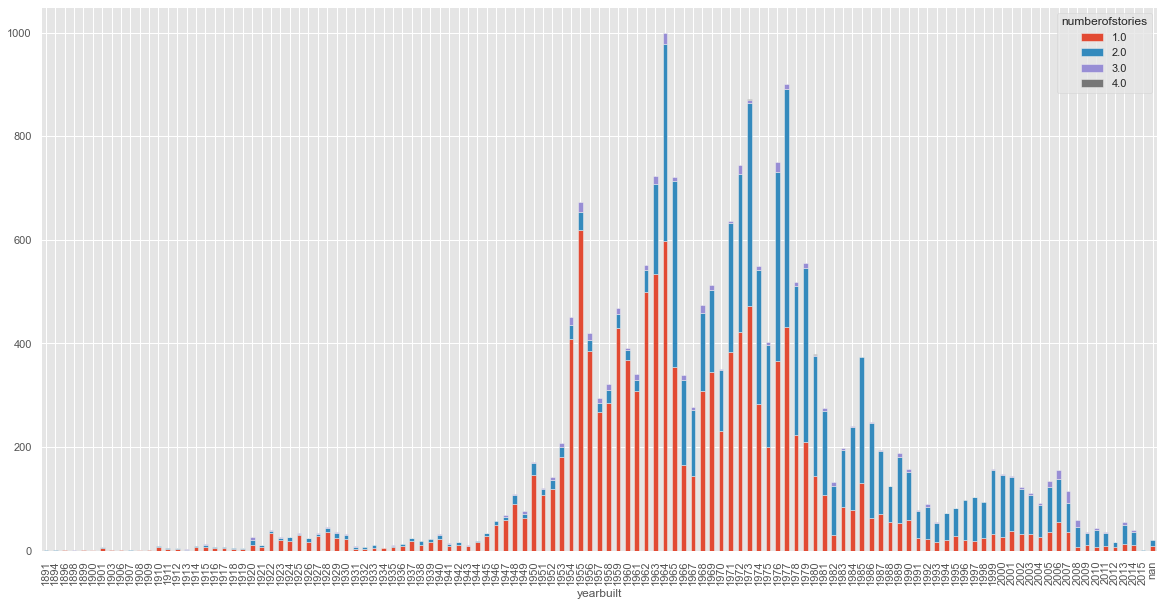

In [103]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
merged['yearbuilt'] = merged['yearbuilt'].map(lambda x: str(x).split('.')[0])
yearMerged = merged.groupby(['yearbuilt', 'numberofstories'])['parcelid'].count().unstack('numberofstories').fillna(0)
yearMerged.plot(kind='bar', stacked=True, ax=ax1)

In [105]:
cols = ["bathroomcnt","bedroomcnt","roomcnt","numberofstories","logerror","calculatedfinishedsquarefeet"]
mergedFiltered = merged[cols].dropna()
for col in cols:
    ulimit = np.percentile(mergedFiltered[col].values, 99.5)
    llimit = np.percentile(mergedFiltered[col].values, 0.5)
    mergedFiltered[col][mergedFiltered[col]>ulimit] = ulimit
    mergedFiltered[col][mergedFiltered[col]<llimit] = llimit

## Calculated Finished Square Feet vs Log Error

Text(0.5, 66.49999999999991, 'Calculated Finished Square Feet')

<Figure size 576x576 with 0 Axes>

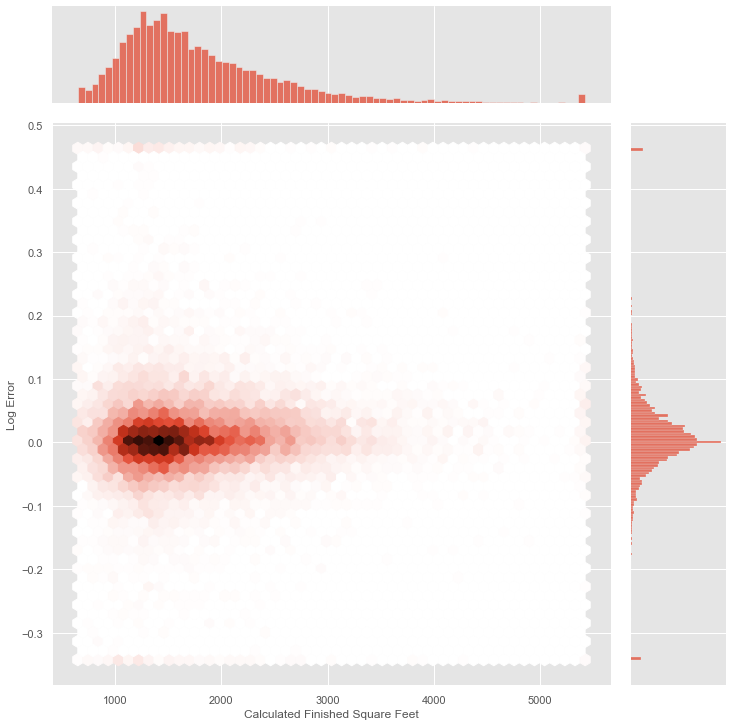

In [106]:
plt.figure(figsize=(8,8))
sns.jointplot(x=mergedFiltered.calculatedfinishedsquarefeet.values, y=mergedFiltered.logerror.values, size=10, kind='hex')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated Finished Square Feet', fontsize=12)

## Bedroom Count vs Log Error

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Bedroom Count'),
 Text(0.5, 1.0, 'Bedroom Count vs Log Error')]

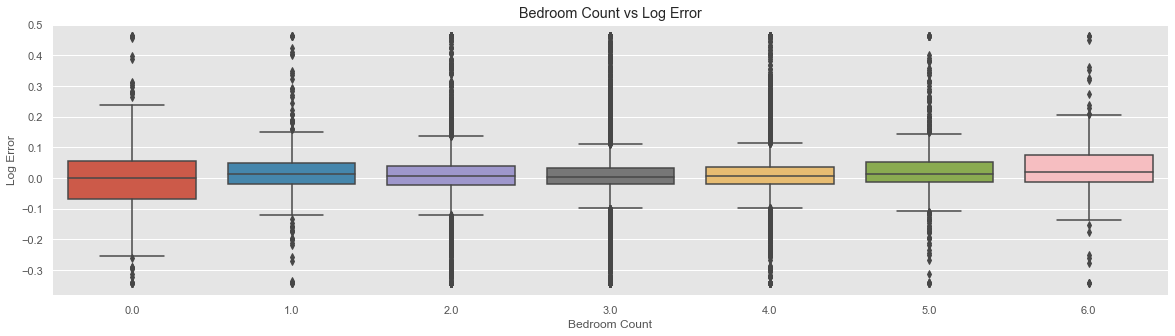

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot(x='bedroomcnt', y='logerror', data=mergedFiltered, ax=ax)
ax.set(ylabel='Log Error', xlabel='Bedroom Count', title='Bedroom Count vs Log Error')

## Bathroom Count vs Log Error

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Bathroom Count'),
 Text(0.5, 1.0, 'Bathroom Count vs Log Error')]

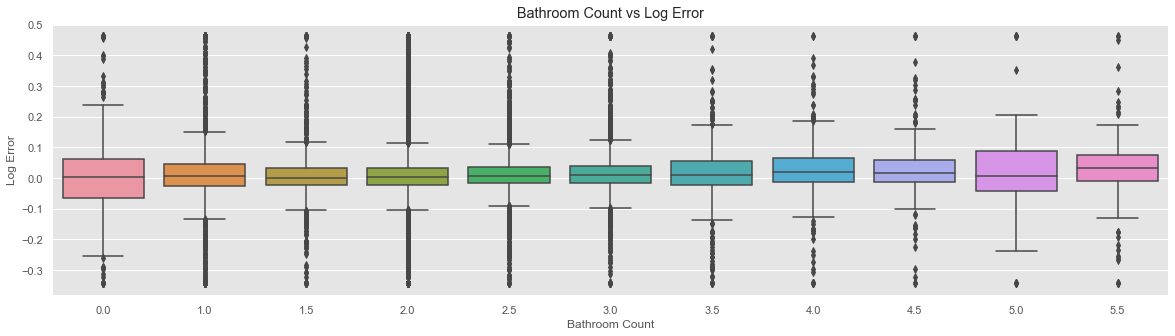

In [108]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot(x='bathroomcnt', y='logerror', data=mergedFiltered, ax=ax)
ax.set(ylabel='Log Error', xlabel='Bathroom Count', title='Bathroom Count vs Log Error')

## Room Count vs Log Error

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Room Count'),
 Text(0.5, 1.0, 'Room Count vs Log Error')]

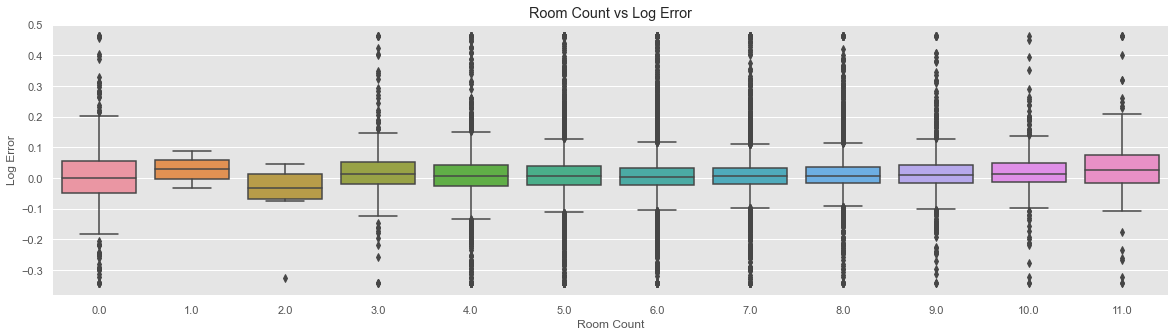

In [109]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot(x='roomcnt', y='logerror', data=mergedFiltered, ax=ax)
ax.set(ylabel='Log Error', xlabel='Room Count', title='Room Count vs Log Error')

## No of storeys vs Log Error

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'No Of Storyes'),
 Text(0.5, 1.0, 'No Of Storeys vs Log Error')]

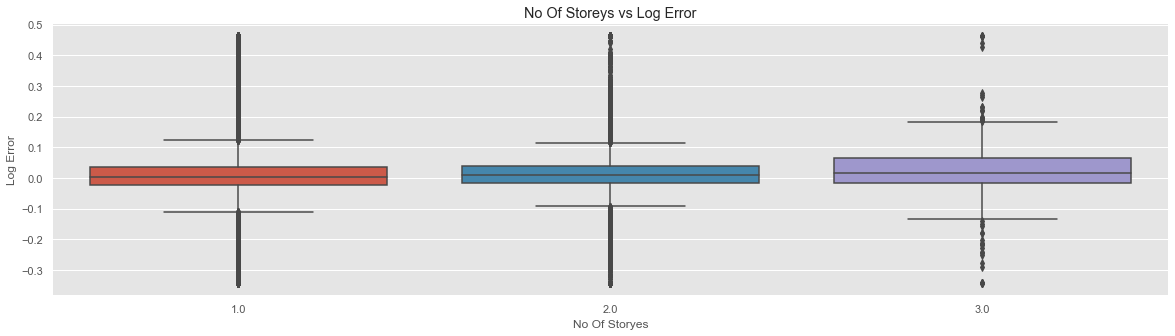

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot(x='numberofstories', y='logerror', data=mergedFiltered, ax=ax)
ax.set(ylabel='Log Error', xlabel='No Of Storyes', title='No Of Storeys vs Log Error')

## Bedroom vs Bathroom vs Log Error

Text(0.5, 0, 'Log Error')

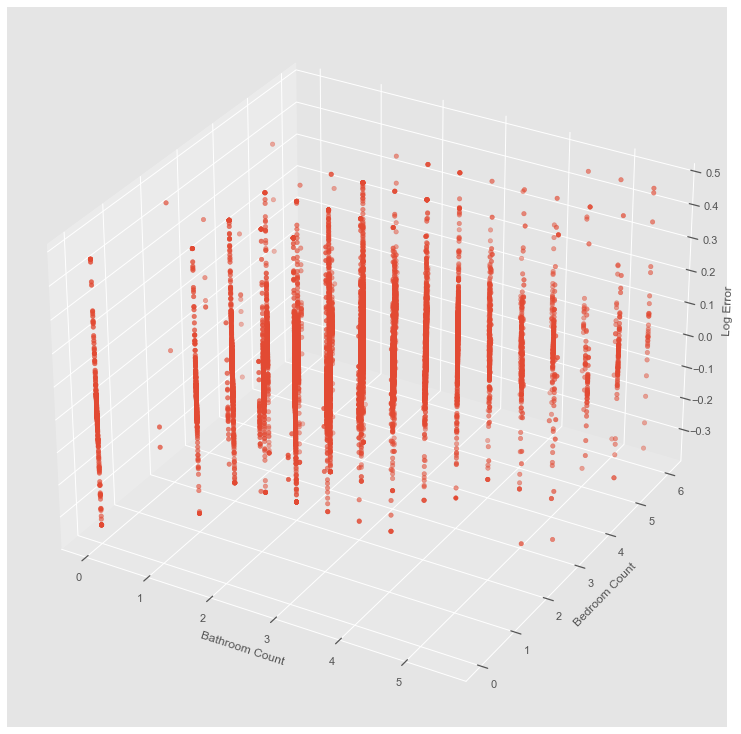

In [111]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
fig = pylab.figure()
fig.set_size_inches(20, 10)
ax = Axes3D(fig)

ax.scatter(mergedFiltered.bathroomcnt, mergedFiltered.bedroomcnt, mergedFiltered.logerror)
ax.set_xlabel('Bathroom Count')
ax.set_ylabel('Bedroom Count')
ax.set_zlabel('Log Error')